In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [2]:
# Set plotting style
plt.style.use('seaborn-white')

# Metadata saved to output plots
METADATA = {
    "Contributor": "Alexander Gude",
    "Rights": "CC-BY-SA 4.0"
}

In [3]:
%matplotlib inline

In [4]:
# Show all columns
pd.set_option('display.max_columns', None)

In [5]:
START_YEAR = 2019
LAST_YEAR = 2020

SQL_FILE = "./v1.1.0-converted_with_sts_v3.0.1-switrs.sqlite"

In [6]:
# Date conversion function
def date_columns(query):
    """If a date column is included in the query, parse it as a date in the
    dataframe."""
    dates = []
    fields = ["collision_date", "process_date"]
    if '*' in query:
        dates = fields
    else:
        for date in fields:
            if date in query:
                dates.append(date)

        if not dates:
            dates = None

    return dates

In [7]:
def run_query(query, sql_file):
    """ Read sqlite query results into a pandas DataFrame. """
    with sqlite3.connect(sql_file) as con:
        # Construct a Dataframe from the results
        df = pd.read_sql_query(
            query,
            con,
            parse_dates = date_columns(query),
        )

        return df

In [8]:
# We should be able to just set rcParams, expect Jupyter has a bug:
# https://github.com/jupyter/notebook/issues/3385
#
# So we have to call this function every time we want to plot.

def setup_plot(title=None, xlabel=None, ylabel=None):
    """Set up a simple, single pane plot with custom configuration.
    
    Args:
        title (str, optional): The title of the plot.
        xlabel (str, optional): The xlabel of the plot.
        ylabel (str, optional): The ylabel of the plot.
        
    Returns:
        (fig, ax): A Matplotlib figure and axis object.
        
    """
    # Plot Size
    plt.rcParams["figure.figsize"] = (12, 7)  # (Width, height)
    
    # Text Size
    SMALL = 12
    MEDIUM = 16
    LARGE = 20
    HUGE = 28
    plt.rcParams["axes.titlesize"] = HUGE
    plt.rcParams["figure.titlesize"] = HUGE
    plt.rcParams["axes.labelsize"] = LARGE
    plt.rcParams["legend.fontsize"] = LARGE
    plt.rcParams["xtick.labelsize"] = MEDIUM
    plt.rcParams["ytick.labelsize"] = MEDIUM
    plt.rcParams["font.size"] = SMALL
    
    # Legend
    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.framealpha"] = 1
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.edgecolor"] = "black"
    
    # Figure output
    plt.rcParams["savefig.dpi"] = 300
    
    # Make the plol
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Make the title and label area opaque instead of transparent
    fig.patch.set_facecolor(ax.get_facecolor())
    
    return fig, ax

In [9]:
def draw_colored_text_legend_instead_of_real_legend(ax, texts, positions):
    legend = ax.get_legend()
    for patch, text, (x, y) in zip(legend.get_patches(), texts, positions):
        color = patch.get_edgecolor()
        ax.text(x, y, text, color=color, verticalalignment='center', transform=ax.transAxes, fontsize=24)
        
    legend.remove()

In [10]:
def save_plot(fig, filename):
    """Save the plot with metadata and tight layout.
    
    Args:
        fig (matplotlib figure): The figure to save.
        filename (str): The loction to save the file to.
    
    """
    metadata = METADATA
    
    fig.savefig(
        fname=f"{filename}", 
        bbox_inches="tight",
        metadata=metadata,
    )

# Fatality Rate by Week

In [11]:
DATE_COL = "collision_date"
CRASH_COL = "crashes"
FATALITY_COL = "fatalities"

query = f"""
    SELECT collision_date
        , 1 as {CRASH_COL}
        , IIF(COLLISION_SEVERITY='fatal', 1, 0) as {FATALITY_COL}
    FROM collisions 
    WHERE {DATE_COL} IS NOT NULL 
    AND {DATE_COL} BETWEEN '{START_YEAR}-01-01' AND '{LAST_YEAR}-11-30'
"""

df = run_query(query, SQL_FILE)

df = df.astype({
    f"{DATE_COL}": "datetime64[ns]",
    CRASH_COL: "int32",
    FATALITY_COL: "int32",
})

In [12]:
df.head()

,collision_date,crashes,fatalities
0,2020-03-14,1,0
1,2020-07-26,1,0
2,2020-10-05,1,0
3,2020-08-06,1,0
4,2020-10-05,1,0


In [13]:
df.dtypes

collision_date    datetime64[ns]
crashes                    int32
fatalities                 int32
dtype: object

In [14]:
ts = df[[DATE_COL, CRASH_COL, FATALITY_COL]]
ts.index= ts[DATE_COL]

ts_series = ts.resample('W-MON').sum()

ts_series["fatality_rate"] = ts_series[FATALITY_COL] / ts_series[CRASH_COL]

ts_series.loc[ts_series.index >= '2020-03-19', "is_after_order"] = True
ts_series.loc[ts_series.index < '2020-03-19', "is_after_order"] = False

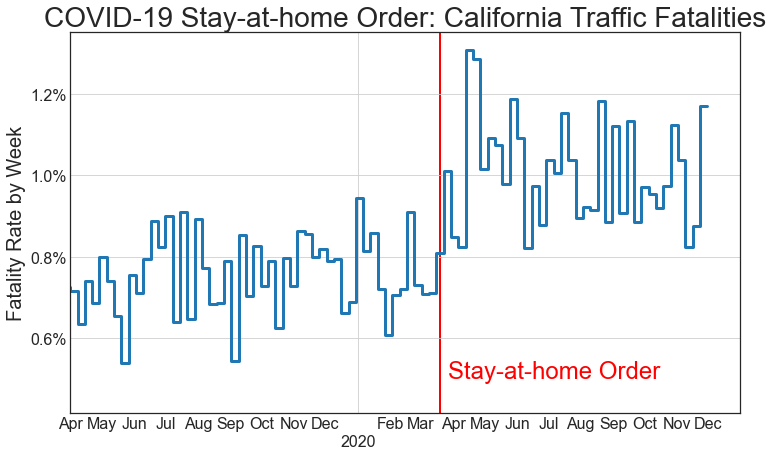

In [15]:
# Convert to a timeseries
fig, ax = setup_plot(
    title="COVID-19 Stay-at-home Order: California Traffic Fatalities",
    ylabel="Fatality Rate by Week",
)

fig.patch.set_facecolor('white')

ax.step(x=ts_series.index, y=ts_series["fatality_rate"], linewidth=3)

# Set Y range and grid
ax.grid(which="major")
ax.set_xlim((pd.Timestamp(f"{START_YEAR}-04-01"), pd.Timestamp(f"{LAST_YEAR}-12-31")))

# Set major ticks
year_locator = mdates.YearLocator()
year_form = mdates.DateFormatter("\n%Y")  # \n puts it one line down
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(year_form)

# Set minor ticks
month_locator = mdates.MonthLocator(interval=1)
month_form = mdates.DateFormatter("%b")
ax.xaxis.set_minor_locator(month_locator)
ax.xaxis.set_minor_formatter(month_form)

# Set Y major ticks
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

# Add Stay at home order
ax.axvline(x=pd.Timestamp("2020-03-19"), color="red", linewidth=2, zorder=-1, label="Stay at home order")
ax.text(x=pd.Timestamp("2020-03-27"), y=0.005, s="Stay-at-home Order", color="red", fontsize=24)


# Add shaded bands for every other year
#draw_bands(ax)

for ext in ("png", "svg"):
    save_plot(fig, filename=f"/tmp/fatality_rate_per_week_in_california_after_covid.{ext}")

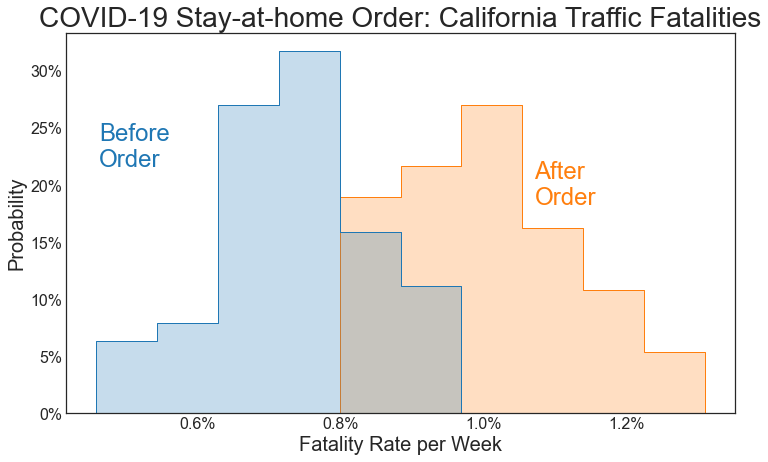

In [16]:
# Convert to a timeseries
fig, ax = setup_plot(
    title="COVID-19 Stay-at-home Order: California Traffic Fatalities",
    xlabel="Fatality Rate per Week",
    ylabel="Probability",
)

sns.histplot(data=ts_series, x="fatality_rate", hue="is_after_order", stat="probability", element="step", common_norm=False, ax=ax)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))


draw_colored_text_legend_instead_of_real_legend(ax, ["Before\nOrder", "After\nOrder"], [(0.05, 0.7), (0.7, 0.6)])

for ext in ("png", "svg"):
    save_plot(fig, filename=f"/tmp/fatality_rate_per_week_in_california_after_covid_histograms.{ext}")

In [17]:
after_mean = np.mean(ts_series[ts_series["is_after_order"]==True]["fatality_rate"])
after_std = np.std(ts_series[ts_series["is_after_order"]==True]["fatality_rate"])

before_mean = np.mean(ts_series[ts_series["is_after_order"]==False]["fatality_rate"])
before_std = np.std(ts_series[ts_series["is_after_order"]==False]["fatality_rate"])

In [18]:
print(after_mean, after_std)
print(before_mean, before_std)

0.010039223850026327 0.001304807519781597
0.007368403075185052 0.001037972165601508


In [19]:
from scipy.stats import mannwhitneyu

mannwhitneyu(
    x=ts_series[ts_series["is_after_order"]==True]["fatality_rate"],
    y=ts_series[ts_series["is_after_order"]==False]["fatality_rate"],
)

MannwhitneyuResult(statistic=2227.0, pvalue=3.59535754806577e-14)

In [20]:
ts_series[ts_series["is_after_order"]==True]["fatality_rate"].values

array([0.00809957, 0.01012096, 0.00849257, 0.00822689, 0.01309942,
       0.01286239, 0.01016884, 0.0109182 , 0.01074896, 0.00979535,
       0.01188575, 0.0109319 , 0.00821141, 0.00974745, 0.00877715,
       0.01038012, 0.01005471, 0.01152867, 0.01037806, 0.00894104,
       0.00921342, 0.00915209, 0.01184339, 0.00884833, 0.01122684,
       0.00908698, 0.01133518, 0.00886503, 0.00972099, 0.00954021,
       0.00919456, 0.00973074, 0.01125363, 0.01037426, 0.00823932,
       0.00874453, 0.01171238])

In [21]:
ts_series[ts_series["is_after_order"]==False]["fatality_rate"].values

array([0.00913806, 0.0065648 , 0.00675752, 0.00763787, 0.00539276,
       0.00751797, 0.00584086, 0.00622212, 0.00642982, 0.00457561,
       0.00792896, 0.0060955 , 0.00726014, 0.00714704, 0.00634633,
       0.00739176, 0.00686185, 0.00800089, 0.0073883 , 0.00653875,
       0.00539018, 0.00753769, 0.00711315, 0.00793562, 0.00887679,
       0.00822902, 0.00900101, 0.00638273, 0.00909193, 0.00646992,
       0.00893655, 0.00771985, 0.00683723, 0.00686499, 0.00789907,
       0.00542092, 0.00854523, 0.00702012, 0.00826358, 0.00726714,
       0.00789872, 0.0062474 , 0.00797019, 0.00727081, 0.00862712,
       0.00856844, 0.00799672, 0.00818599, 0.00789663, 0.00793651,
       0.00661157, 0.0068804 , 0.00943396, 0.00814664, 0.00857213,
       0.00720444, 0.0060769 , 0.00704814, 0.0071934 , 0.00910896,
       0.0073051 , 0.00707903, 0.00711061])